# Lagrangian trajectories in the Gulf Stream area: movies



In [1]:
# import libraries

%matplotlib inline
import os, shutil
from glob import glob
import re
#from netCDF4 import Dataset
#import numpy as np
import xarray as xr
import dask
dask.config.set(scheduler='synchronous')
#
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean
import cartopy.crs as ccrs
import gsw

from clib.flow import *

/home1/homedir5/perso/aponte/.miniconda3/envs/cognac/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
# load grid info
grd = grid()

# output files
ofiles = sorted(glob(grd._datadir+'*avg*.nc'))

ds = xr.open_mfdataset(ofiles, concat_dim='time', chunks={'time': 1, 's_rho': 1, 's_w': 1}, compat='equals') #.chunk(chunks={'time': 1})
print(ds)

1 grid file found, uses: /home/datawork-lops-osi/jgula/NESED/nesea_grd.nc
-- Grid object
dim lon_rho: 1602  2002
lon_rho min= -72.123, max=-58.273
lat_rho min= 34.123, max=43.734
h min= 20.000, max=5543.070
<xarray.Dataset>
Dimensions:     (auxil: 4, eta_rho: 1602, eta_v: 1601, s_rho: 50, s_w: 51, time: 1300, xi_rho: 2002, xi_u: 2001)
Coordinates:
  * time        (time) float64 6.48e+07 6.481e+07 6.481e+07 6.481e+07 ...
Dimensions without coordinates: auxil, eta_rho, eta_v, s_rho, s_w, xi_rho, xi_u
Data variables:
    time_step   (time, auxil) int32 dask.array<shape=(1300, 4), chunksize=(1, 4)>
    scrum_time  (time) float32 dask.array<shape=(1300,), chunksize=(1,)>
    zeta        (time, eta_rho, xi_rho) float32 dask.array<shape=(1300, 1602, 2002), chunksize=(1, 1602, 2002)>
    ubar        (time, eta_rho, xi_u) float32 dask.array<shape=(1300, 1602, 2001), chunksize=(1, 1602, 2001)>
    vbar        (time, eta_v, xi_rho) float32 dask.array<shape=(1300, 1601, 2002), chunksize=(1, 1601, 

In [3]:
ldatadir = '/home/datawork-lops-osi/jgula/Cognac/north/'
lfiles = sorted(glob(ldatadir+'*.nc'))

# open files
lds = [xr.open_dataset(file) for file in lfiles]
print(lds[0])

dt_particles = lds[0].ocean_time[1]-lds[0].ocean_time[0]
print('dt_particles = %.1f' %dt_particles)

depth = [-l.depth for l in lds]
print('depth of different simulations:' , depth)

# convert list of datasets into a dict of datasets
lds = dict(zip(depth,lds))

# conmpute the offset between ds.time and lds.ocean_time
dt = find_dt(lds[0], ds, ofiles)
# ds.time/86400. = (d.ocean_time+dt)/86400.

<xarray.Dataset>
Dimensions:     (nq: 10037, time: 360)
Coordinates:
  * time        (time) float32 60.0 61.0 62.0 63.0 64.0 65.0 66.0 67.0 68.0 ...
Dimensions without coordinates: nq
Data variables:
    ocean_time  (time) float32 ...
    px          (time, nq) float64 ...
    py          (time, nq) float64 ...
    pt          (time, nq) float64 ...
    ps          (time, nq) float64 ...
    pu          (time, nq) float64 ...
    pv          (time, nq) float64 ...
    plon        (time, nq) float64 ...
    plat        (time, nq) float64 ...
    ptopo       (time, nq) float64 ...
    prho        (time, nq) float64 ...
    prho1       (time, nq) float64 ...
Attributes:
    description:  particles tracking
    simulation:   nesed_avg [0,10000,0,10000,[1,100,1]] 60
    sub:          360
    base:         0
    ng:           1
    x_periodic:   0
    y_periodic:   0
    depth:        0
dt_particles = 3600.0
depth of different simulations: [0, 50, 100, 200, 300, 400, 500]


In [4]:
# useful parameters

# initial mass center
lon0, lat0 = lds[0].plon.isel(time=0).mean().values, lds[0].plat.isel(time=0).mean().values
# metric terms
dlon = 111.e3 * np.cos(np.pi/180.*lat0)
dlat = 111.e3

nq = {}
for d in [2, 5, 10, 20]:
    sources = []
    sources.append([-d*1.e3, -d*1.e3])
    sources.append([-d*1.e3, d*1.e3])
    sources.append([d*1.e3, d*1.e3])
    sources.append([d*1.e3, -d*1.e3])
    nq[d] = np.array([get_nq( lds[0], lon0+s[0]/dlon, lat0+s[1]/dlat ) for s in sources])

# colors
cols = cm.plasma(np.linspace(0,1,len(nq)))
cols = dict(zip(nq.keys(),[cols[i,:] for i in range(cols.shape[0])]))

---

## Initial position

Text(0.5,1,'surface temperature [degC]')

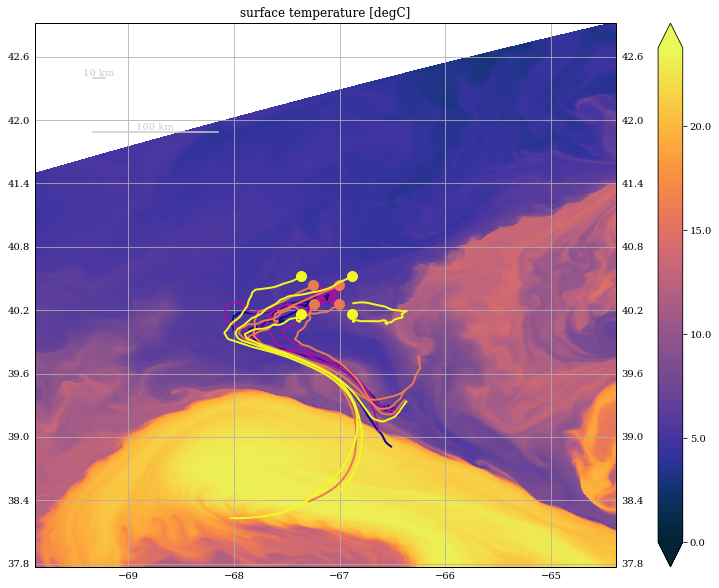

In [5]:
crs = ccrs.PlateCarree()
#cmap = plt.get_cmap('magma')
cmap = cmocean.cm.thermal

fig=plt.figure(figsize=(15,10))
#
ax=plt.axes(projection=crs)
#ax.set_extent(grd.hextent, crs)
ax.set_extent(get_hextent(lds[0].isel(time=0), dlon=2., dlat=2.), crs)
gl=ax.gridlines(crs=crs,draw_labels=True)
gl.xlabels_top = False
ax.coastlines(resolution='50m')
#
iz = -1
toplt = ds['temp'].isel(time=0, s_rho=iz).values
im = ax.pcolormesh(grd['lon_rho'],grd['lat_rho'], toplt,
                   vmin=toplt.min(),vmax=toplt.max(), 
                   cmap=cmap, transform=crs)
cbar = plt.colorbar(im, format='%.1f', extend='both')


for d in [2, 5, 10, 20]:
    l = lds[0].isel(nq=nq[d]).isel(time=slice(0,24*10))
    ax.plot(l.plon.isel(time=0),l.plat.isel(time=0),'o', color=cols[d], markersize=10, transform=crs)
    ax.plot(l.plon,l.plat, color=cols[d], lw=2, transform=crs)

# plot scale
plot_scale(ax, 10.e3, y_offset=0., color='.8')
plot_scale(ax, 100.e3, y_offset=0.1, color='.8')

ax.set_title('surface temperature [degC]')

#plt.savefig('figs/T_hmap.png',dpi=300)

## at a given time

In [6]:
# potentially need to resample SST data, here both are hourly
#ds = ds.resample(time=dt)
# and then interp
print('dt parcels : %0.f s' %dt_particles)
print('dt avg outputs : %0.f s' %(ds.time[1]-ds.time[0]))


dt parcels : 3600 s
dt avg outputs : 3600 s


Text(0.5,1,'surface temperature [degC]')

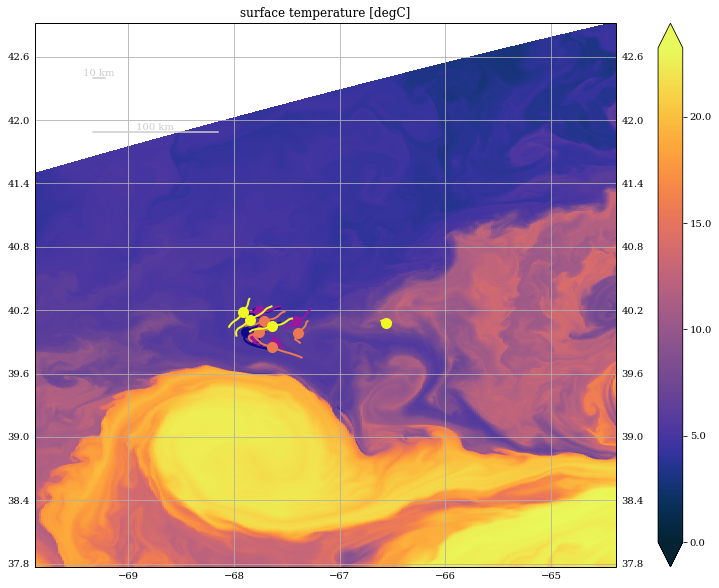

In [7]:
it = 100
t = lds[0].isel(time=it).ocean_time
# ds.time/86400. = (lds.ocean_time+dt)/86400.

fig=plt.figure(figsize=(15,10))
#
ax=plt.axes(projection=crs)
#ax.set_extent(grd.hextent, crs)
ax.set_extent(get_hextent(lds[0].isel(time=0), dlon=2., dlat=2.), crs)
gl=ax.gridlines(crs=crs,draw_labels=True)
gl.xlabels_top = False
#ax.coastlines(resolution='50m')
#
iz = -1

toplt = ds['temp'].sel(time=t+dt).isel(s_rho=iz).values
#toplt = ds['temp'].isel(time=0, s_rho=iz).values
im = ax.pcolormesh(grd['lon_rho'],grd['lat_rho'], toplt,
                   vmin=toplt.min(),vmax=toplt.max(), 
                   cmap=cmap, transform=crs)
cbar = plt.colorbar(im, format='%.1f', extend='both')

for d in [2, 5, 10, 20]:
    l = lds[0].isel(nq=nq[d])
    ax.plot(l.plon.isel(time=it),l.plat.isel(time=it),'o', color=cols[d], markersize=10, transform=crs)
    ax.plot(l.plon.isel(time=slice(it-24,it+24)),l.plat.isel(time=slice(it-24,it+24)), \
            color=cols[d], lw=2, transform=crs)

# plot scale
plot_scale(ax, 10.e3, y_offset=0., color='.8')
plot_scale(ax, 100.e3, y_offset=0.1, color='.8')
    
ax.set_title('surface temperature [degC]')

#plt.savefig('figs/T_hmap.png',dpi=300)

---

## loop over time to create movie

### focus on sources

In [8]:
# add lon/lat to ds coords, should be done earlier
ds = xr.merge([ds, grd['lon_rho'], grd['lat_rho']]).set_coords(['lon_rho', 'lat_rho'])
print(ds)

<xarray.Dataset>
Dimensions:     (auxil: 4, eta_rho: 1602, eta_v: 1601, s_rho: 50, s_w: 51, time: 1300, xi_rho: 2002, xi_u: 2001)
Coordinates:
  * time        (time) float64 6.48e+07 6.481e+07 6.481e+07 6.481e+07 ...
    lon_rho     (eta_rho, xi_rho) float64 -68.81 -68.81 -68.8 -68.8 -68.79 ...
    lat_rho     (eta_rho, xi_rho) float64 34.12 34.12 34.13 34.13 34.13 ...
Dimensions without coordinates: auxil, eta_rho, eta_v, s_rho, s_w, xi_rho, xi_u
Data variables:
    time_step   (time, auxil) int32 dask.array<shape=(1300, 4), chunksize=(1, 4)>
    scrum_time  (time) float32 dask.array<shape=(1300,), chunksize=(1,)>
    zeta        (time, eta_rho, xi_rho) float32 dask.array<shape=(1300, 1602, 2002), chunksize=(1, 1602, 2002)>
    ubar        (time, eta_rho, xi_u) float32 dask.array<shape=(1300, 1602, 2001), chunksize=(1, 1602, 2001)>
    vbar        (time, eta_v, xi_rho) float32 dask.array<shape=(1300, 1601, 2002), chunksize=(1, 1601, 2002)>
    u           (time, s_rho, eta_rho, xi_u) 

In [ ]:
ti = lds[0].ocean_time.values

figdir = '/home2/pharos/othr/aponte/figs/'
shutil.rmtree(figdir, ignore_errors=True); os.mkdir(figdir)

plt.switch_backend('agg')

for it, t in enumerate(ti):
        
    fig=plt.figure(figsize=(15,10))
    
    #
    ax=plt.axes(projection=crs)
    #ax.set_extent(grd.hextent, crs)
    ax.set_extent(get_hextent(lds[0].isel(time=it), dlon=.5, dlat=.5), crs)
    gl=ax.gridlines(crs=crs,draw_labels=True)
    gl.xlabels_top = False
    #ax.coastlines(resolution='50m')
    #
    iz = -1
    toplt = ds['temp'].sel(time=t+dt).isel(s_rho=iz)
    im = toplt.plot(ax=ax, x='lon_rho', y='lat_rho', vmin=3., vmax=23., 
               cmap=cmap, transform=crs, add_colorbar=False)
    #toplt = ds['temp'].sel(time=t+dt).isel(s_rho=iz).values
    #im = ax.pcolormesh(grd['lon_rho'],grd['lat_rho'], toplt,
    #                   vmin=3.,vmax=23., 
    #                   cmap=cmap, transform=crs)
    cbar = plt.colorbar(im, format='%.1f', extend='both')

    # floats
    l = lds[200]
    ax.plot(l.plon.isel(time=it),l.plat.isel(time=it),'.', color='w', \
            markersize=1, transform=crs)

    # plot sources
    for d in [2, 5, 10, 20]:
        l = lds[0].isel(nq=nq[d])
        ax.plot(l.plon.isel(time=it),l.plat.isel(time=it),'o', color=cols[d], \
                markersize=10, transform=crs)
        if it>1:
            ax.plot(l.plon.isel(time=slice(max(it-24,0),it)), \
                    l.plat.isel(time=slice(max(it-24,0),it)), \
                    color=cols[d], lw=2, transform=crs)
    
    # plot scale
    plot_scale(ax, 10.e3, y_offset=0., color='.8')
    plot_scale(ax, 100.e3, y_offset=0.1, color='.8')
            
    ax.set_title('t = %0.2f d'%((t-ti[0])/86400.))

    fig.savefig(figdir+'sst_ltraj_%03d.png'%it, dpi=150)
    plt.close(fig)
    
    print('%d / %d'%(it, ti.size-1))


0 / 359
1 / 359
2 / 359
3 / 359
4 / 359
5 / 359
6 / 359
7 / 359
8 / 359
9 / 359
10 / 359
11 / 359
12 / 359
13 / 359
14 / 359
15 / 359
16 / 359
17 / 359
18 / 359
19 / 359
20 / 359
21 / 359
22 / 359
23 / 359
24 / 359
25 / 359
26 / 359
27 / 359
28 / 359
29 / 359
30 / 359
31 / 359
32 / 359
33 / 359
34 / 359
35 / 359
36 / 359
37 / 359
38 / 359
39 / 359
40 / 359
41 / 359
42 / 359
43 / 359
44 / 359
45 / 359
46 / 359
47 / 359
48 / 359
49 / 359
50 / 359
51 / 359
52 / 359
53 / 359
54 / 359
55 / 359
56 / 359
57 / 359
58 / 359
59 / 359
60 / 359
61 / 359
62 / 359
63 / 359
64 / 359
65 / 359
66 / 359
67 / 359
68 / 359
69 / 359
70 / 359
71 / 359
72 / 359
73 / 359
74 / 359
75 / 359
76 / 359
77 / 359
78 / 359
79 / 359
80 / 359
81 / 359
82 / 359
83 / 359
84 / 359
85 / 359
86 / 359
87 / 359
88 / 359
89 / 359
90 / 359
91 / 359
92 / 359
93 / 359
94 / 359
95 / 359
96 / 359
97 / 359
98 / 359
99 / 359
100 / 359
101 / 359
102 / 359
103 / 359
104 / 359
105 / 359
106 / 359
107 / 359
108 / 359
109 / 359
110 / 359


### focus on floats
    

In [ ]:
# select floats

# initial grid of floats
dx, dy = np.mgrid[-5:5:3j,-5:5:3j] *1e3

nqf = {}
for d in depth:
    floats = []
    nqf[d] = np.array([get_nq( lds[d], lon0+ldx/dlon, lat0+ldy/dlat ) for ldx, ldy in zip(dx.flatten(),dy.flatten())])

# colors
colsf = cm.Accent(np.linspace(0,1,len(nqf)))
colsf = dict(zip(nqf.keys(),[colsf[i,:] for i in range(colsf.shape[0])]))


In [ ]:
ti = lds[0].ocean_time.values

figdir = '/home2/pharos/othr/aponte/figsf/'
shutil.rmtree(figdir, ignore_errors=True); os.mkdir(figdir)

plt.switch_backend('agg')

for it, t in enumerate(ti):
        
    fig=plt.figure(figsize=(15,10))
    
    #
    ax=plt.axes(projection=crs)
    #ax.set_extent(grd.hextent, crs)
    ax.set_extent(get_hextent(lds[0].isel(time=it), dlon=.5, dlat=.5), crs)
    gl=ax.gridlines(crs=crs,draw_labels=True)
    gl.xlabels_top = False
    ax.coastlines(resolution='50m')
    #
    iz = -1
    toplt = ds['temp'].sel(time=t+dt).isel(s_rho=iz)
    im = toplt.plot(ax=ax, x='lon_rho', y='lat_rho', vmin=3., vmax=23., 
               cmap=cmap, transform=crs, add_colorbar=False)
    cbar = plt.colorbar(im, format='%.1f', extend='both')

    # floats
    for d in [400,200,100]:    
        l = lds[d].isel(nq=nqf[d])
        if it>1:
            ax.plot(l.plon.isel(time=slice(max(it-24,0),it)), \
                    l.plat.isel(time=slice(max(it-24,0),it)), \
                    color=colsf[d], lw=1, transform=crs)
    hdl=[]
    for d in [400,200,100]:
        l = lds[d].isel(nq=nqf[d])
        hdl += ax.plot(l.plon.isel(time=it),l.plat.isel(time=it),'D', color=colsf[d], \
                    markersize=5, transform=crs, label='z=-%.0fm'%d, markeredgecolor='w')
        # markeredgewidth=1
    plt.legend(handles=hdl, loc='upper right')
            
    # plot sources
    for d in [10]:
        l = lds[0].isel(nq=nq[d])
        ax.plot(l.plon.isel(time=it),l.plat.isel(time=it),'o', color=cols[d], \
                markersize=10, transform=crs)
    
    # plot scale
    plot_scale(ax, 10.e3, y_offset=0., color='.8')
    plot_scale(ax, 100.e3, y_offset=0.1, color='.8')
            
    ax.set_title('t = %0.2f d'%((t-ti[0])/86400.))

    plt.savefig(figdir+'sst_ltraj_%03d.png'%it, dpi=150)
    plt.close(fig)
    
    print('%d / %d'%(it, ti.size-1))
